Convolutional Dictionary Learning with Spatial Mask
===================================================

This example demonstrates the use of [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn) for convolutional dictionary learning with a spatial mask, from a set of greyscale training images. The dictionary learning algorithm is based on the hybrid mask decoupling / ADMM consensus dictionary update [[15]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2017-convolutional).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdndl
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.25, gray=True)
S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
S = np.dstack((S1, S2))

Construct initial dictionary.

In [3]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 32)

Create random mask and apply to training images.

In [4]:
t = 0.5
W = np.random.randn(*(S.shape[0:2] + (1,)))
W[np.abs(W) > t] = 1;
W[np.abs(W) < t] = 0;
Sw = W * S

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter.

In [5]:
lmbda = 0.1
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
            'DFidWeight': W, 'gEvalY': False, 'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(Sw, lmbda, opt)
sl = b.solve()
sh = Sw - sl

CDL without a spatial mask using [admm.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNDictLearn).

In [6]:
lmbda = 0.05
opt1 = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 50.0*lmbda + 0.5},
            'CCMOD': {'rho': 1e2}})
d1 = cbpdndl.ConvBPDNDictLearn(D0, sh, lmbda, opt1)
D1 = d1.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  5.39e+02  4.15e+02  2.47e+03  9.32e-16  6.03e-01  5.77e-01  3.00e+00  9.67e-02  9.46e-02  1.00e+02
   1  3.35e+02  5.20e+01  5.65e+03  8.86e-16  2.87e-01  7.11e-01  3.00e+00  1.29e-01  2.43e-01  1.00e+02


   2  2.78e+02  2.34e+01  5.10e+03  7.23e-16  2.21e-01  4.15e-01  3.00e+00  6.78e-02  1.73e-01  1.00e+02
   3  2.31e+02  2.75e+01  4.06e+03  9.84e-16  1.70e-01  3.85e-01  3.00e+00  6.87e-02  1.56e-01  1.00e+02


   4  2.28e+02  3.16e+01  3.93e+03  6.40e-16  1.35e-01  2.39e-01  3.00e+00  4.15e-02  1.25e-01  1.00e+02


   5  2.25e+02  1.99e+01  4.09e+03  1.03e-15  9.67e-02  2.07e-01  3.00e+00  3.12e-02  1.30e-01  1.00e+02


   6  2.22e+02  9.94e+00  4.24e+03  9.93e-16  7.56e-02  1.91e-01  3.00e+00  2.65e-02  9.51e-02  1.00e+02
   7  2.17e+02  5.82e+00  4.22e+03  1.01e-15  6.28e-02  1.66e-01  3.00e+00  1.96e-02  1.03e-01  1.00e+02


   8  2.11e+02  9.28e+00  4.04e+03  1.17e-15  5.34e-02  1.64e-01  3.00e+00  1.76e-02  9.13e-02  1.00e+02
   9  2.10e+02  1.59e+01  3.88e+03  1.02e-15  4.60e-02  1.46e-01  3.00e+00  1.59e-02  9.25e-02  1.00e+02


  10  2.09e+02  1.64e+01  3.86e+03  9.02e-16  3.92e-02  1.22e-01  3.00e+00  1.16e-02  8.64e-02  1.00e+02
  11  2.08e+02  1.13e+01  3.93e+03  9.84e-16  3.31e-02  1.19e-01  3.00e+00  1.03e-02  7.65e-02  1.00e+02


  12  2.07e+02  7.96e+00  3.98e+03  1.12e-15  2.92e-02  1.12e-01  3.00e+00  8.94e-03  6.91e-02  1.00e+02


  13  2.05e+02  8.10e+00  3.95e+03  8.87e-16  2.60e-02  1.05e-01  3.00e+00  6.87e-03  6.39e-02  1.00e+02
  14  2.04e+02  1.03e+01  3.88e+03  9.71e-16  2.31e-02  1.02e-01  3.00e+00  6.86e-03  6.38e-02  1.00e+02


  15  2.03e+02  1.18e+01  3.83e+03  1.16e-15  2.10e-02  9.33e-02  3.00e+00  6.23e-03  6.41e-02  1.00e+02


  16  2.03e+02  1.15e+01  3.82e+03  1.22e-15  1.90e-02  8.66e-02  3.00e+00  5.05e-03  6.15e-02  1.00e+02
  17  2.02e+02  1.02e+01  3.84e+03  9.58e-16  1.74e-02  8.35e-02  3.00e+00  4.55e-03  5.75e-02  1.00e+02


  18  2.02e+02  9.14e+00  3.85e+03  1.01e-15  1.61e-02  8.01e-02  3.00e+00  4.16e-03  5.40e-02  1.00e+02
  19  2.01e+02  8.93e+00  3.84e+03  7.96e-16  1.51e-02  7.69e-02  3.00e+00  3.71e-03  5.17e-02  1.00e+02


  20  2.00e+02  9.40e+00  3.82e+03  8.98e-16  1.41e-02  7.43e-02  3.00e+00  3.58e-03  5.06e-02  1.00e+02
  21  2.00e+02  1.00e+01  3.80e+03  1.14e-15  1.33e-02  7.13e-02  3.00e+00  3.52e-03  4.97e-02  1.00e+02


  22  1.99e+02  1.03e+01  3.78e+03  8.06e-16  1.25e-02  6.78e-02  3.00e+00  3.26e-03  4.84e-02  1.00e+02


  23  1.99e+02  9.99e+00  3.78e+03  9.68e-16  1.18e-02  6.52e-02  3.00e+00  2.98e-03  4.67e-02  1.00e+02
  24  1.99e+02  9.45e+00  3.79e+03  1.04e-15  1.12e-02  6.33e-02  3.00e+00  2.84e-03  4.49e-02  1.00e+02


  25  1.98e+02  9.11e+00  3.79e+03  9.27e-16  1.07e-02  6.13e-02  3.00e+00  2.70e-03  4.33e-02  1.00e+02
  26  1.98e+02  9.14e+00  3.78e+03  9.60e-16  1.03e-02  5.95e-02  3.00e+00  2.58e-03  4.21e-02  1.00e+02


  27  1.98e+02  9.39e+00  3.76e+03  9.29e-16  9.84e-03  5.79e-02  3.00e+00  2.55e-03  4.12e-02  1.00e+02


  28  1.97e+02  9.60e+00  3.75e+03  9.35e-16  9.44e-03  5.61e-02  3.00e+00  2.50e-03  4.05e-02  1.00e+02
  29  1.97e+02  9.60e+00  3.75e+03  8.38e-16  9.08e-03  5.43e-02  3.00e+00  2.40e-03  3.96e-02  1.00e+02


  30  1.97e+02  9.42e+00  3.75e+03  9.61e-16  8.74e-03  5.29e-02  3.00e+00  2.30e-03  3.87e-02  1.00e+02
  31  1.96e+02  9.22e+00  3.75e+03  9.75e-16  8.43e-03  5.15e-02  3.00e+00  2.23e-03  3.78e-02  1.00e+02


  32  1.96e+02  9.12e+00  3.74e+03  9.03e-16  8.15e-03  5.02e-02  3.00e+00  2.17e-03  3.69e-02  1.00e+02


  33  1.96e+02  9.14e+00  3.74e+03  9.73e-16  7.88e-03  4.89e-02  3.00e+00  2.12e-03  3.62e-02  1.00e+02


  34  1.96e+02  9.21e+00  3.73e+03  8.34e-16  7.62e-03  4.77e-02  3.00e+00  2.08e-03  3.55e-02  1.00e+02


  35  1.95e+02  9.25e+00  3.72e+03  9.92e-16  7.37e-03  4.65e-02  3.00e+00  2.04e-03  3.48e-02  1.00e+02


  36  1.95e+02  9.21e+00  3.72e+03  8.19e-16  7.15e-03  4.53e-02  3.00e+00  1.99e-03  3.42e-02  1.00e+02
  37  1.95e+02  9.13e+00  3.72e+03  1.07e-15  6.93e-03  4.43e-02  3.00e+00  1.94e-03  3.35e-02  1.00e+02


  38  1.95e+02  9.06e+00  3.71e+03  9.07e-16  6.74e-03  4.34e-02  3.00e+00  1.90e-03  3.28e-02  1.00e+02


  39  1.94e+02  9.02e+00  3.71e+03  9.44e-16  6.56e-03  4.25e-02  3.00e+00  1.86e-03  3.22e-02  1.00e+02
  40  1.94e+02  9.01e+00  3.70e+03  9.68e-16  6.39e-03  4.17e-02  3.00e+00  1.83e-03  3.17e-02  1.00e+02


  41  1.94e+02  9.02e+00  3.70e+03  1.09e-15  6.23e-03  4.08e-02  3.00e+00  1.80e-03  3.12e-02  1.00e+02


  42  1.94e+02  9.01e+00  3.70e+03  8.08e-16  6.07e-03  4.00e-02  3.00e+00  1.78e-03  3.07e-02  1.00e+02
  43  1.94e+02  8.98e+00  3.69e+03  9.34e-16  5.93e-03  3.92e-02  3.00e+00  1.75e-03  3.02e-02  1.00e+02


  44  1.93e+02  8.95e+00  3.69e+03  1.11e-15  5.79e-03  3.85e-02  3.00e+00  1.72e-03  2.97e-02  1.00e+02
  45  1.93e+02  8.91e+00  3.68e+03  8.64e-16  5.67e-03  3.78e-02  3.00e+00  1.70e-03  2.93e-02  1.00e+02


  46  1.93e+02  8.88e+00  3.68e+03  8.81e-16  5.55e-03  3.72e-02  3.00e+00  1.67e-03  2.89e-02  1.00e+02
  47  1.93e+02  8.86e+00  3.68e+03  7.96e-16  5.43e-03  3.65e-02  3.00e+00  1.65e-03  2.85e-02  1.00e+02


  48  1.92e+02  8.85e+00  3.67e+03  1.11e-15  5.31e-03  3.59e-02  3.00e+00  1.63e-03  2.81e-02  1.00e+02


  49  1.92e+02  8.85e+00  3.67e+03  1.24e-15  5.21e-03  3.53e-02  3.00e+00  1.61e-03  2.77e-02  1.00e+02
  50  1.92e+02  8.84e+00  3.66e+03  9.67e-16  5.10e-03  3.47e-02  3.00e+00  1.59e-03  2.73e-02  1.00e+02


  51  1.92e+02  8.81e+00  3.66e+03  1.13e-15  5.01e-03  3.42e-02  3.00e+00  1.57e-03  2.70e-02  1.00e+02


  52  1.92e+02  8.78e+00  3.66e+03  9.73e-16  4.91e-03  3.37e-02  3.00e+00  1.55e-03  2.66e-02  1.00e+02
  53  1.91e+02  8.75e+00  3.65e+03  8.82e-16  4.82e-03  3.32e-02  3.00e+00  1.53e-03  2.63e-02  1.00e+02


  54  1.91e+02  8.73e+00  3.65e+03  1.02e-15  4.74e-03  3.27e-02  3.00e+00  1.52e-03  2.59e-02  1.00e+02


  55  1.91e+02  8.72e+00  3.65e+03  1.02e-15  4.66e-03  3.23e-02  3.00e+00  1.50e-03  2.56e-02  1.00e+02


  56  1.91e+02  8.71e+00  3.64e+03  1.00e-15  4.59e-03  3.18e-02  3.00e+00  1.49e-03  2.53e-02  1.00e+02


  57  1.91e+02  8.69e+00  3.64e+03  9.69e-16  4.51e-03  3.14e-02  3.00e+00  1.47e-03  2.50e-02  1.00e+02


  58  1.90e+02  8.68e+00  3.63e+03  7.95e-16  4.43e-03  3.10e-02  3.00e+00  1.46e-03  2.47e-02  1.00e+02


  59  1.90e+02  8.65e+00  3.63e+03  8.86e-16  4.36e-03  3.06e-02  3.00e+00  1.45e-03  2.44e-02  1.00e+02


  60  1.90e+02  8.63e+00  3.63e+03  7.13e-16  4.30e-03  3.02e-02  3.00e+00  1.43e-03  2.41e-02  1.00e+02
  61  1.90e+02  8.61e+00  3.62e+03  8.35e-16  4.24e-03  2.98e-02  3.00e+00  1.42e-03  2.38e-02  1.00e+02


  62  1.90e+02  8.60e+00  3.62e+03  8.76e-16  4.18e-03  2.95e-02  3.00e+00  1.41e-03  2.35e-02  1.00e+02
  63  1.89e+02  8.58e+00  3.62e+03  9.58e-16  4.12e-03  2.92e-02  3.00e+00  1.39e-03  2.32e-02  1.00e+02


  64  1.89e+02  8.57e+00  3.61e+03  9.92e-16  4.07e-03  2.88e-02  3.00e+00  1.38e-03  2.29e-02  1.00e+02


  65  1.89e+02  8.55e+00  3.61e+03  1.01e-15  4.02e-03  2.85e-02  3.00e+00  1.37e-03  2.27e-02  1.00e+02


  66  1.89e+02  8.53e+00  3.60e+03  9.32e-16  3.97e-03  2.82e-02  3.00e+00  1.36e-03  2.24e-02  1.00e+02


  67  1.89e+02  8.51e+00  3.60e+03  7.92e-16  3.92e-03  2.80e-02  3.00e+00  1.35e-03  2.22e-02  1.00e+02


  68  1.88e+02  8.50e+00  3.60e+03  1.05e-15  3.88e-03  2.77e-02  3.00e+00  1.34e-03  2.20e-02  1.00e+02


  69  1.88e+02  8.48e+00  3.59e+03  1.03e-15  3.84e-03  2.75e-02  3.00e+00  1.33e-03  2.18e-02  1.00e+02


  70  1.88e+02  8.46e+00  3.59e+03  8.48e-16  3.79e-03  2.72e-02  3.00e+00  1.32e-03  2.16e-02  1.00e+02


  71  1.88e+02  8.44e+00  3.59e+03  8.11e-16  3.76e-03  2.70e-02  3.00e+00  1.31e-03  2.13e-02  1.00e+02


  72  1.88e+02  8.42e+00  3.58e+03  1.05e-15  3.72e-03  2.68e-02  3.00e+00  1.30e-03  2.11e-02  1.00e+02


  73  1.87e+02  8.41e+00  3.58e+03  8.19e-16  3.69e-03  2.66e-02  3.00e+00  1.29e-03  2.09e-02  1.00e+02
  74  1.87e+02  8.39e+00  3.57e+03  9.29e-16  3.65e-03  2.64e-02  3.00e+00  1.29e-03  2.07e-02  1.00e+02


  75  1.87e+02  8.38e+00  3.57e+03  1.01e-15  3.62e-03  2.62e-02  3.00e+00  1.28e-03  2.05e-02  1.00e+02


  76  1.87e+02  8.36e+00  3.57e+03  9.40e-16  3.59e-03  2.60e-02  3.00e+00  1.27e-03  2.03e-02  1.00e+02


  77  1.86e+02  8.35e+00  3.56e+03  1.13e-15  3.56e-03  2.58e-02  3.00e+00  1.26e-03  2.01e-02  1.00e+02


  78  1.86e+02  8.33e+00  3.56e+03  1.07e-15  3.53e-03  2.57e-02  3.00e+00  1.26e-03  1.99e-02  1.00e+02


  79  1.86e+02  8.31e+00  3.55e+03  9.18e-16  3.51e-03  2.56e-02  3.00e+00  1.25e-03  1.97e-02  1.00e+02


  80  1.86e+02  8.29e+00  3.55e+03  1.03e-15  3.49e-03  2.54e-02  3.00e+00  1.24e-03  1.95e-02  1.00e+02
  81  1.86e+02  8.28e+00  3.55e+03  9.57e-16  3.47e-03  2.53e-02  3.00e+00  1.24e-03  1.94e-02  1.00e+02


  82  1.85e+02  8.27e+00  3.54e+03  7.35e-16  3.45e-03  2.52e-02  3.00e+00  1.23e-03  1.92e-02  1.00e+02


  83  1.85e+02  8.26e+00  3.54e+03  1.01e-15  3.42e-03  2.50e-02  3.00e+00  1.23e-03  1.90e-02  1.00e+02


  84  1.85e+02  8.24e+00  3.53e+03  1.13e-15  3.41e-03  2.49e-02  3.00e+00  1.22e-03  1.89e-02  1.00e+02


  85  1.85e+02  8.22e+00  3.53e+03  8.08e-16  3.39e-03  2.48e-02  3.00e+00  1.22e-03  1.87e-02  1.00e+02


  86  1.85e+02  8.20e+00  3.53e+03  9.19e-16  3.37e-03  2.46e-02  3.00e+00  1.21e-03  1.86e-02  1.00e+02


  87  1.84e+02  8.19e+00  3.52e+03  8.82e-16  3.35e-03  2.45e-02  3.00e+00  1.21e-03  1.84e-02  1.00e+02


  88  1.84e+02  8.18e+00  3.52e+03  8.97e-16  3.33e-03  2.44e-02  3.00e+00  1.20e-03  1.82e-02  1.00e+02


  89  1.84e+02  8.17e+00  3.51e+03  1.08e-15  3.31e-03  2.42e-02  3.00e+00  1.20e-03  1.81e-02  1.00e+02


  90  1.84e+02  8.15e+00  3.51e+03  8.37e-16  3.29e-03  2.41e-02  3.00e+00  1.19e-03  1.80e-02  1.00e+02


  91  1.83e+02  8.13e+00  3.51e+03  7.81e-16  3.27e-03  2.40e-02  3.00e+00  1.19e-03  1.78e-02  1.00e+02
  92  1.83e+02  8.12e+00  3.50e+03  7.98e-16  3.26e-03  2.39e-02  3.00e+00  1.18e-03  1.77e-02  1.00e+02


  93  1.83e+02  8.10e+00  3.50e+03  1.04e-15  3.24e-03  2.38e-02  3.00e+00  1.18e-03  1.76e-02  1.00e+02


  94  1.83e+02  8.09e+00  3.49e+03  9.79e-16  3.23e-03  2.37e-02  3.00e+00  1.17e-03  1.75e-02  1.00e+02


  95  1.83e+02  8.08e+00  3.49e+03  8.36e-16  3.22e-03  2.36e-02  3.00e+00  1.17e-03  1.74e-02  1.00e+02


  96  1.82e+02  8.07e+00  3.49e+03  1.06e-15  3.20e-03  2.35e-02  3.00e+00  1.16e-03  1.73e-02  1.00e+02


  97  1.82e+02  8.05e+00  3.48e+03  1.02e-15  3.19e-03  2.34e-02  3.00e+00  1.16e-03  1.71e-02  1.00e+02


  98  1.82e+02  8.04e+00  3.48e+03  7.64e-16  3.18e-03  2.34e-02  3.00e+00  1.16e-03  1.70e-02  1.00e+02


  99  1.82e+02  8.02e+00  3.47e+03  1.03e-15  3.16e-03  2.33e-02  3.00e+00  1.16e-03  1.69e-02  1.00e+02
 100  1.81e+02  8.01e+00  3.47e+03  7.51e-16  3.16e-03  2.32e-02  3.00e+00  1.15e-03  1.68e-02  1.00e+02


 101  1.81e+02  8.00e+00  3.46e+03  7.55e-16  3.15e-03  2.32e-02  3.00e+00  1.15e-03  1.67e-02  1.00e+02
 102  1.81e+02  7.99e+00  3.46e+03  8.13e-16  3.14e-03  2.31e-02  3.00e+00  1.15e-03  1.66e-02  1.00e+02


 103  1.81e+02  7.98e+00  3.46e+03  8.29e-16  3.13e-03  2.30e-02  3.00e+00  1.14e-03  1.64e-02  1.00e+02


 104  1.81e+02  7.97e+00  3.45e+03  9.73e-16  3.12e-03  2.30e-02  3.00e+00  1.14e-03  1.63e-02  1.00e+02


 105  1.80e+02  7.95e+00  3.45e+03  9.82e-16  3.11e-03  2.29e-02  3.00e+00  1.14e-03  1.62e-02  1.00e+02


 106  1.80e+02  7.94e+00  3.44e+03  1.08e-15  3.11e-03  2.29e-02  3.00e+00  1.13e-03  1.61e-02  1.00e+02


 107  1.80e+02  7.93e+00  3.44e+03  1.09e-15  3.10e-03  2.28e-02  3.00e+00  1.13e-03  1.60e-02  1.00e+02


 108  1.80e+02  7.92e+00  3.44e+03  8.88e-16  3.09e-03  2.28e-02  3.00e+00  1.12e-03  1.59e-02  1.00e+02


 109  1.79e+02  7.91e+00  3.43e+03  1.23e-15  3.09e-03  2.27e-02  3.00e+00  1.12e-03  1.58e-02  1.00e+02


 110  1.79e+02  7.89e+00  3.43e+03  9.00e-16  3.08e-03  2.27e-02  3.00e+00  1.12e-03  1.57e-02  1.00e+02


 111  1.79e+02  7.88e+00  3.42e+03  1.19e-15  3.08e-03  2.27e-02  3.00e+00  1.11e-03  1.56e-02  1.00e+02


 112  1.79e+02  7.87e+00  3.42e+03  9.49e-16  3.07e-03  2.26e-02  3.00e+00  1.11e-03  1.55e-02  1.00e+02


 113  1.79e+02  7.86e+00  3.42e+03  8.94e-16  3.07e-03  2.26e-02  3.00e+00  1.11e-03  1.54e-02  1.00e+02


 114  1.78e+02  7.85e+00  3.41e+03  9.24e-16  3.06e-03  2.26e-02  3.00e+00  1.11e-03  1.53e-02  1.00e+02
 115  1.78e+02  7.84e+00  3.41e+03  9.32e-16  3.06e-03  2.25e-02  3.00e+00  1.11e-03  1.52e-02  1.00e+02


 116  1.78e+02  7.83e+00  3.40e+03  8.98e-16  3.06e-03  2.25e-02  3.00e+00  1.10e-03  1.51e-02  1.00e+02


 117  1.78e+02  7.82e+00  3.40e+03  7.34e-16  3.06e-03  2.25e-02  3.00e+00  1.10e-03  1.51e-02  1.00e+02
 118  1.78e+02  7.81e+00  3.39e+03  8.66e-16  3.06e-03  2.25e-02  3.00e+00  1.10e-03  1.50e-02  1.00e+02


 119  1.77e+02  7.80e+00  3.39e+03  7.47e-16  3.05e-03  2.25e-02  3.00e+00  1.10e-03  1.49e-02  1.00e+02


 120  1.77e+02  7.79e+00  3.39e+03  8.83e-16  3.05e-03  2.25e-02  3.00e+00  1.09e-03  1.48e-02  1.00e+02


 121  1.77e+02  7.78e+00  3.38e+03  1.10e-15  3.06e-03  2.25e-02  3.00e+00  1.09e-03  1.48e-02  1.00e+02


 122  1.77e+02  7.77e+00  3.38e+03  9.98e-16  3.06e-03  2.25e-02  3.00e+00  1.09e-03  1.47e-02  1.00e+02


 123  1.76e+02  7.76e+00  3.37e+03  1.33e-15  3.06e-03  2.25e-02  3.00e+00  1.09e-03  1.47e-02  1.00e+02
 124  1.76e+02  7.75e+00  3.37e+03  9.82e-16  3.06e-03  2.26e-02  3.00e+00  1.09e-03  1.46e-02  1.00e+02


 125  1.76e+02  7.74e+00  3.37e+03  9.50e-16  3.07e-03  2.26e-02  3.00e+00  1.09e-03  1.45e-02  1.00e+02


 126  1.76e+02  7.73e+00  3.36e+03  1.01e-15  3.07e-03  2.26e-02  3.00e+00  1.09e-03  1.45e-02  1.00e+02


 127  1.76e+02  7.72e+00  3.36e+03  7.72e-16  3.07e-03  2.26e-02  3.00e+00  1.09e-03  1.44e-02  1.00e+02


 128  1.75e+02  7.70e+00  3.35e+03  1.01e-15  3.08e-03  2.26e-02  3.00e+00  1.09e-03  1.44e-02  1.00e+02


 129  1.75e+02  7.70e+00  3.35e+03  9.04e-16  3.08e-03  2.26e-02  3.00e+00  1.09e-03  1.43e-02  1.00e+02


 130  1.75e+02  7.69e+00  3.34e+03  9.83e-16  3.09e-03  2.27e-02  3.00e+00  1.09e-03  1.43e-02  1.00e+02
 131  1.75e+02  7.69e+00  3.34e+03  7.31e-16  3.10e-03  2.27e-02  3.00e+00  1.09e-03  1.42e-02  1.00e+02


 132  1.74e+02  7.68e+00  3.34e+03  8.31e-16  3.10e-03  2.27e-02  3.00e+00  1.09e-03  1.42e-02  1.00e+02


 133  1.74e+02  7.67e+00  3.33e+03  9.62e-16  3.11e-03  2.28e-02  3.00e+00  1.09e-03  1.41e-02  1.00e+02


 134  1.74e+02  7.66e+00  3.33e+03  8.52e-16  3.12e-03  2.28e-02  3.00e+00  1.09e-03  1.41e-02  1.00e+02
 135  1.74e+02  7.65e+00  3.32e+03  8.58e-16  3.13e-03  2.29e-02  3.00e+00  1.09e-03  1.40e-02  1.00e+02


 136  1.74e+02  7.65e+00  3.32e+03  1.06e-15  3.14e-03  2.30e-02  3.00e+00  1.09e-03  1.40e-02  1.00e+02
 137  1.73e+02  7.64e+00  3.31e+03  8.84e-16  3.14e-03  2.30e-02  3.00e+00  1.09e-03  1.39e-02  1.00e+02


 138  1.73e+02  7.64e+00  3.31e+03  9.30e-16  3.15e-03  2.30e-02  3.00e+00  1.09e-03  1.39e-02  1.00e+02


 139  1.73e+02  7.63e+00  3.31e+03  8.81e-16  3.16e-03  2.31e-02  3.00e+00  1.09e-03  1.39e-02  1.00e+02
 140  1.73e+02  7.62e+00  3.30e+03  9.87e-16  3.17e-03  2.31e-02  3.00e+00  1.10e-03  1.38e-02  1.00e+02


 141  1.72e+02  7.62e+00  3.30e+03  8.09e-16  3.18e-03  2.32e-02  3.00e+00  1.10e-03  1.38e-02  1.00e+02


 142  1.72e+02  7.61e+00  3.29e+03  9.09e-16  3.19e-03  2.32e-02  3.00e+00  1.10e-03  1.38e-02  1.00e+02
 143  1.72e+02  7.61e+00  3.29e+03  9.20e-16  3.20e-03  2.33e-02  3.00e+00  1.10e-03  1.38e-02  1.00e+02


 144  1.72e+02  7.60e+00  3.28e+03  1.03e-15  3.21e-03  2.34e-02  3.00e+00  1.10e-03  1.37e-02  1.00e+02
 145  1.72e+02  7.59e+00  3.28e+03  1.05e-15  3.22e-03  2.34e-02  3.00e+00  1.10e-03  1.37e-02  1.00e+02


 146  1.71e+02  7.59e+00  3.28e+03  8.90e-16  3.23e-03  2.35e-02  3.00e+00  1.10e-03  1.37e-02  1.00e+02
 147  1.71e+02  7.58e+00  3.27e+03  9.52e-16  3.24e-03  2.36e-02  3.00e+00  1.11e-03  1.36e-02  1.00e+02


 148  1.71e+02  7.57e+00  3.27e+03  8.23e-16  3.26e-03  2.36e-02  3.00e+00  1.11e-03  1.36e-02  1.00e+02


 149  1.71e+02  7.57e+00  3.26e+03  1.06e-15  3.27e-03  2.37e-02  3.00e+00  1.11e-03  1.36e-02  1.00e+02
 150  1.70e+02  7.57e+00  3.26e+03  1.01e-15  3.28e-03  2.38e-02  3.00e+00  1.11e-03  1.36e-02  1.00e+02


 151  1.70e+02  7.56e+00  3.25e+03  9.93e-16  3.30e-03  2.39e-02  3.00e+00  1.11e-03  1.36e-02  1.00e+02


 152  1.70e+02  7.56e+00  3.25e+03  9.47e-16  3.31e-03  2.39e-02  3.00e+00  1.12e-03  1.36e-02  1.00e+02


 153  1.70e+02  7.55e+00  3.25e+03  8.92e-16  3.33e-03  2.40e-02  3.00e+00  1.12e-03  1.36e-02  1.00e+02


 154  1.70e+02  7.55e+00  3.24e+03  8.77e-16  3.34e-03  2.41e-02  3.00e+00  1.12e-03  1.35e-02  1.00e+02


 155  1.69e+02  7.54e+00  3.24e+03  9.73e-16  3.36e-03  2.42e-02  3.00e+00  1.12e-03  1.35e-02  1.00e+02


 156  1.69e+02  7.54e+00  3.23e+03  9.96e-16  3.37e-03  2.43e-02  3.00e+00  1.13e-03  1.35e-02  1.00e+02
 157  1.69e+02  7.53e+00  3.23e+03  9.65e-16  3.39e-03  2.44e-02  3.00e+00  1.13e-03  1.35e-02  1.00e+02


 158  1.69e+02  7.53e+00  3.22e+03  1.18e-15  3.40e-03  2.45e-02  3.00e+00  1.13e-03  1.35e-02  1.00e+02
 159  1.68e+02  7.53e+00  3.22e+03  9.86e-16  3.42e-03  2.46e-02  3.00e+00  1.14e-03  1.35e-02  1.00e+02


 160  1.68e+02  7.52e+00  3.22e+03  9.05e-16  3.43e-03  2.47e-02  3.00e+00  1.14e-03  1.35e-02  1.00e+02


 161  1.68e+02  7.52e+00  3.21e+03  8.11e-16  3.44e-03  2.47e-02  3.00e+00  1.14e-03  1.35e-02  1.00e+02


 162  1.68e+02  7.52e+00  3.21e+03  6.57e-16  3.46e-03  2.48e-02  3.00e+00  1.15e-03  1.35e-02  1.00e+02


 163  1.68e+02  7.51e+00  3.20e+03  9.04e-16  3.48e-03  2.49e-02  3.00e+00  1.15e-03  1.35e-02  1.00e+02
 164  1.67e+02  7.51e+00  3.20e+03  8.50e-16  3.49e-03  2.50e-02  3.00e+00  1.15e-03  1.35e-02  1.00e+02


 165  1.67e+02  7.51e+00  3.19e+03  8.64e-16  3.51e-03  2.51e-02  3.00e+00  1.16e-03  1.35e-02  1.00e+02


 166  1.67e+02  7.51e+00  3.19e+03  9.43e-16  3.52e-03  2.52e-02  3.00e+00  1.16e-03  1.35e-02  1.00e+02


 167  1.67e+02  7.50e+00  3.19e+03  8.13e-16  3.54e-03  2.53e-02  3.00e+00  1.17e-03  1.36e-02  1.00e+02
 168  1.67e+02  7.50e+00  3.18e+03  9.50e-16  3.55e-03  2.53e-02  3.00e+00  1.17e-03  1.36e-02  1.00e+02


 169  1.66e+02  7.50e+00  3.18e+03  8.80e-16  3.57e-03  2.54e-02  3.00e+00  1.17e-03  1.36e-02  1.00e+02
 170  1.66e+02  7.50e+00  3.17e+03  9.18e-16  3.59e-03  2.55e-02  3.00e+00  1.18e-03  1.36e-02  1.00e+02


 171  1.66e+02  7.50e+00  3.17e+03  9.46e-16  3.60e-03  2.56e-02  3.00e+00  1.18e-03  1.36e-02  1.00e+02


 172  1.66e+02  7.50e+00  3.16e+03  9.39e-16  3.62e-03  2.57e-02  3.00e+00  1.19e-03  1.36e-02  1.00e+02
 173  1.65e+02  7.50e+00  3.16e+03  1.09e-15  3.64e-03  2.58e-02  3.00e+00  1.19e-03  1.37e-02  1.00e+02


 174  1.65e+02  7.49e+00  3.15e+03  9.21e-16  3.66e-03  2.59e-02  3.00e+00  1.20e-03  1.37e-02  1.00e+02


 175  1.65e+02  7.49e+00  3.15e+03  1.10e-15  3.68e-03  2.61e-02  3.00e+00  1.20e-03  1.38e-02  1.00e+02


 176  1.65e+02  7.49e+00  3.15e+03  1.07e-15  3.70e-03  2.62e-02  3.00e+00  1.21e-03  1.38e-02  1.00e+02


 177  1.65e+02  7.50e+00  3.14e+03  8.96e-16  3.73e-03  2.64e-02  3.00e+00  1.21e-03  1.38e-02  1.00e+02


 178  1.64e+02  7.51e+00  3.14e+03  9.41e-16  3.76e-03  2.65e-02  3.00e+00  1.22e-03  1.39e-02  1.00e+02
 179  1.64e+02  7.51e+00  3.13e+03  9.65e-16  3.78e-03  2.67e-02  3.00e+00  1.23e-03  1.39e-02  1.00e+02


 180  1.64e+02  7.51e+00  3.13e+03  9.46e-16  3.80e-03  2.68e-02  3.00e+00  1.23e-03  1.39e-02  1.00e+02


 181  1.64e+02  7.51e+00  3.12e+03  8.07e-16  3.82e-03  2.69e-02  3.00e+00  1.24e-03  1.40e-02  1.00e+02


 182  1.64e+02  7.50e+00  3.12e+03  1.08e-15  3.84e-03  2.70e-02  3.00e+00  1.25e-03  1.40e-02  1.00e+02


 183  1.63e+02  7.51e+00  3.12e+03  8.42e-16  3.86e-03  2.71e-02  3.00e+00  1.25e-03  1.40e-02  1.00e+02
 184  1.63e+02  7.51e+00  3.11e+03  8.91e-16  3.87e-03  2.72e-02  3.00e+00  1.26e-03  1.41e-02  1.00e+02


 185  1.63e+02  7.51e+00  3.11e+03  7.88e-16  3.89e-03  2.72e-02  3.00e+00  1.26e-03  1.41e-02  1.00e+02


 186  1.63e+02  7.52e+00  3.10e+03  7.98e-16  3.91e-03  2.73e-02  3.00e+00  1.27e-03  1.41e-02  1.00e+02
 187  1.62e+02  7.52e+00  3.10e+03  9.63e-16  3.93e-03  2.74e-02  3.00e+00  1.27e-03  1.42e-02  1.00e+02


 188  1.62e+02  7.52e+00  3.09e+03  8.07e-16  3.95e-03  2.75e-02  3.00e+00  1.28e-03  1.42e-02  1.00e+02


 189  1.62e+02  7.52e+00  3.09e+03  8.94e-16  3.96e-03  2.76e-02  3.00e+00  1.29e-03  1.42e-02  1.00e+02


 190  1.62e+02  7.52e+00  3.09e+03  9.63e-16  3.98e-03  2.77e-02  3.00e+00  1.29e-03  1.43e-02  1.00e+02


 191  1.62e+02  7.53e+00  3.08e+03  8.78e-16  4.00e-03  2.77e-02  3.00e+00  1.30e-03  1.43e-02  1.00e+02


 192  1.61e+02  7.53e+00  3.08e+03  9.34e-16  4.02e-03  2.78e-02  3.00e+00  1.31e-03  1.43e-02  1.00e+02


 193  1.61e+02  7.54e+00  3.07e+03  1.12e-15  4.04e-03  2.79e-02  3.00e+00  1.31e-03  1.43e-02  1.00e+02


 194  1.61e+02  7.54e+00  3.07e+03  9.40e-16  4.05e-03  2.79e-02  3.00e+00  1.32e-03  1.44e-02  1.00e+02


 195  1.61e+02  7.55e+00  3.07e+03  9.98e-16  4.07e-03  2.80e-02  3.00e+00  1.32e-03  1.44e-02  1.00e+02
 196  1.61e+02  7.55e+00  3.06e+03  9.10e-16  4.08e-03  2.81e-02  3.00e+00  1.33e-03  1.45e-02  1.00e+02


 197  1.60e+02  7.55e+00  3.06e+03  8.47e-16  4.10e-03  2.81e-02  3.00e+00  1.33e-03  1.45e-02  1.00e+02
 198  1.60e+02  7.56e+00  3.05e+03  8.76e-16  4.11e-03  2.82e-02  3.00e+00  1.34e-03  1.45e-02  1.00e+02


 199  1.60e+02  7.57e+00  3.05e+03  1.05e-15  4.13e-03  2.83e-02  3.00e+00  1.34e-03  1.46e-02  1.00e+02
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution without a spatial mask.

In [7]:
sr1 = d1.reconstruct().squeeze() + sl

CDL with a spatial mask using [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn). (Note that [parcnsdl.ConvBPDNMaskDcplDictLearn_Consensus](http://sporco.rtfd.org/en/latest/sporco.admm.parcnsdl.html#sporco.admm.parcnsdl.ConvBPDNMaskDcplDictLearn_Consensus) solves the same problem, but is substantially faster on a multi-core architecture.)

In [8]:
opt2 = cbpdndl.ConvBPDNMaskDcplDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 20.0*lmbda + 0.5},
            'CCMOD': {'rho': 2e-1}})
d2 = cbpdndl.ConvBPDNMaskDcplDictLearn(D0, sh, lmbda, W, opt2)
D2 = d2.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  9.69e+01  7.20e+01  4.97e+02  9.69e-16  1.51e-01  9.90e-01  1.50e+00  5.57e-01  1.15e+01  2.00e-01


   1  7.21e+01  4.41e+01  5.59e+02  9.66e-16  2.44e-01  9.25e-01  1.50e+00  7.72e-01  9.10e+00  2.00e-01


   2  1.93e+02  4.46e+01  2.97e+03  1.03e-15  2.04e-01  9.66e-01  1.50e+00  7.39e-01  6.29e+00  2.00e-01


   3  4.88e+02  3.23e+02  3.30e+03  1.05e-15  1.67e-01  9.49e-01  1.50e+00  5.80e-01  1.74e+01  2.00e-01


   4  3.25e+02  1.91e+02  2.69e+03  9.59e-16  1.79e-01  9.46e-01  1.50e+00  4.69e-01  2.31e+00  2.00e-01


   5  3.36e+02  2.15e+02  2.41e+03  8.47e-16  1.51e-01  9.36e-01  1.50e+00  3.83e-01  4.31e+00  2.00e-01


   6  1.12e+02  3.80e+01  1.48e+03  9.11e-16  1.85e-01  1.05e+00  1.50e+00  3.27e-01  9.99e-01  2.00e-01


   7  1.43e+02  8.36e+01  1.19e+03  8.13e-16  1.32e-01  1.09e+00  1.50e+00  2.67e-01  9.82e-01  2.00e-01


   8  1.07e+02  4.57e+01  1.22e+03  8.98e-16  1.41e-01  9.03e-01  1.50e+00  2.30e-01  9.03e-01  2.00e-01


   9  1.06e+02  5.12e+01  1.10e+03  8.57e-16  1.14e-01  9.56e-01  1.50e+00  1.98e-01  1.00e+00  2.00e-01


  10  7.43e+01  2.29e+01  1.03e+03  8.24e-16  1.23e-01  8.71e-01  1.50e+00  1.89e-01  1.96e+00  2.00e-01


  11  9.65e+01  5.32e+01  8.66e+02  8.93e-16  9.88e-02  8.24e-01  1.50e+00  1.67e-01  1.64e+00  2.00e-01


  12  5.26e+01  1.97e+01  6.58e+02  8.16e-16  1.12e-01  7.18e-01  1.50e+00  1.62e-01  6.90e-01  2.00e-01


  13  4.44e+01  1.61e+01  5.64e+02  9.79e-16  8.85e-02  7.13e-01  1.50e+00  1.35e-01  7.06e-01  2.00e-01


  14  3.89e+01  1.37e+01  5.05e+02  8.48e-16  7.33e-02  6.79e-01  1.50e+00  1.24e-01  9.84e-01  2.00e-01


  15  3.38e+01  1.24e+01  4.29e+02  9.35e-16  6.11e-02  6.12e-01  1.50e+00  1.17e-01  1.19e+00  2.00e-01


  16  3.01e+01  1.17e+01  3.68e+02  9.53e-16  5.14e-02  5.44e-01  1.50e+00  1.19e-01  1.12e+00  2.00e-01


  17  2.79e+01  1.14e+01  3.29e+02  8.50e-16  4.35e-02  4.93e-01  1.50e+00  1.20e-01  8.95e-01  2.00e-01


  18  2.64e+01  1.08e+01  3.11e+02  9.76e-16  3.83e-02  4.61e-01  1.50e+00  1.16e-01  7.04e-01  2.00e-01


  19  2.51e+01  9.70e+00  3.08e+02  1.08e-15  3.40e-02  4.43e-01  1.50e+00  1.04e-01  5.39e-01  2.00e-01


  20  2.41e+01  8.55e+00  3.10e+02  9.85e-16  3.12e-02  4.42e-01  1.50e+00  9.50e-02  4.26e-01  2.00e-01


  21  2.34e+01  7.79e+00  3.13e+02  1.11e-15  2.91e-02  4.48e-01  1.50e+00  8.91e-02  3.98e-01  2.00e-01


  22  2.30e+01  7.44e+00  3.11e+02  9.77e-16  2.74e-02  4.55e-01  1.50e+00  8.67e-02  4.11e-01  2.00e-01


  23  2.25e+01  7.27e+00  3.05e+02  1.01e-15  2.60e-02  4.56e-01  1.50e+00  8.65e-02  4.13e-01  2.00e-01


  24  2.20e+01  7.14e+00  2.98e+02  1.33e-15  2.51e-02  4.47e-01  1.50e+00  8.71e-02  4.00e-01  2.00e-01


  25  2.16e+01  6.99e+00  2.93e+02  1.08e-15  2.37e-02  4.28e-01  1.50e+00  8.71e-02  3.90e-01  2.00e-01


  26  2.13e+01  6.72e+00  2.92e+02  9.65e-16  2.29e-02  4.06e-01  1.50e+00  8.52e-02  3.91e-01  2.00e-01


  27  2.11e+01  6.39e+00  2.94e+02  1.08e-15  2.23e-02  3.86e-01  1.50e+00  8.33e-02  3.91e-01  2.00e-01


  28  2.11e+01  6.14e+00  2.99e+02  8.64e-16  2.17e-02  3.72e-01  1.50e+00  8.25e-02  3.77e-01  2.00e-01


  29  2.11e+01  5.96e+00  3.02e+02  1.05e-15  2.09e-02  3.66e-01  1.50e+00  8.04e-02  3.36e-01  2.00e-01


  30  2.09e+01  5.76e+00  3.03e+02  1.21e-15  2.04e-02  3.66e-01  1.50e+00  7.70e-02  3.02e-01  2.00e-01
  31  2.05e+01  5.52e+00  3.01e+02  9.94e-16  1.97e-02  3.68e-01  1.50e+00  7.53e-02  3.15e-01  2.00e-01


  32  2.02e+01  5.37e+00  2.96e+02  8.65e-16  1.92e-02  3.69e-01  1.50e+00  7.39e-02  3.46e-01  2.00e-01
  33  1.99e+01  5.43e+00  2.90e+02  8.97e-16  1.87e-02  3.65e-01  1.50e+00  7.23e-02  3.54e-01  2.00e-01


  34  1.98e+01  5.58e+00  2.84e+02  9.07e-16  1.82e-02  3.58e-01  1.50e+00  7.07e-02  3.34e-01  2.00e-01


  35  1.96e+01  5.71e+00  2.79e+02  1.07e-15  1.78e-02  3.46e-01  1.50e+00  6.91e-02  3.02e-01  2.00e-01


  36  1.95e+01  5.75e+00  2.75e+02  9.25e-16  1.74e-02  3.34e-01  1.50e+00  6.70e-02  2.74e-01  2.00e-01
  37  1.94e+01  5.72e+00  2.73e+02  1.03e-15  1.71e-02  3.24e-01  1.50e+00  6.45e-02  2.65e-01  2.00e-01


  38  1.93e+01  5.62e+00  2.73e+02  8.38e-16  1.68e-02  3.16e-01  1.50e+00  6.22e-02  2.68e-01  2.00e-01


  39  1.92e+01  5.49e+00  2.74e+02  9.95e-16  1.66e-02  3.12e-01  1.50e+00  6.04e-02  2.71e-01  2.00e-01


  40  1.91e+01  5.34e+00  2.75e+02  1.04e-15  1.63e-02  3.10e-01  1.50e+00  5.98e-02  2.68e-01  2.00e-01


  41  1.90e+01  5.20e+00  2.76e+02  6.84e-16  1.60e-02  3.08e-01  1.50e+00  6.01e-02  2.62e-01  2.00e-01


  42  1.89e+01  5.07e+00  2.77e+02  9.51e-16  1.57e-02  3.06e-01  1.50e+00  6.10e-02  2.56e-01  2.00e-01


  43  1.88e+01  4.97e+00  2.77e+02  9.06e-16  1.55e-02  3.01e-01  1.50e+00  6.01e-02  2.49e-01  2.00e-01


  44  1.88e+01  4.88e+00  2.78e+02  9.25e-16  1.53e-02  2.95e-01  1.50e+00  5.91e-02  2.38e-01  2.00e-01


  45  1.87e+01  4.78e+00  2.79e+02  1.08e-15  1.51e-02  2.89e-01  1.50e+00  5.84e-02  2.27e-01  2.00e-01
  46  1.87e+01  4.68e+00  2.81e+02  7.47e-16  1.50e-02  2.83e-01  1.50e+00  5.78e-02  2.20e-01  2.00e-01


  47  1.87e+01  4.57e+00  2.83e+02  7.69e-16  1.48e-02  2.80e-01  1.50e+00  5.73e-02  2.22e-01  2.00e-01


  48  1.87e+01  4.48e+00  2.84e+02  9.71e-16  1.46e-02  2.77e-01  1.50e+00  5.64e-02  2.29e-01  2.00e-01


  49  1.86e+01  4.42e+00  2.85e+02  1.02e-15  1.44e-02  2.74e-01  1.50e+00  5.46e-02  2.33e-01  2.00e-01
  50  1.86e+01  4.42e+00  2.83e+02  1.05e-15  1.41e-02  2.71e-01  1.50e+00  5.26e-02  2.31e-01  2.00e-01


  51  1.85e+01  4.49e+00  2.80e+02  1.09e-15  1.40e-02  2.67e-01  1.50e+00  5.13e-02  2.21e-01  2.00e-01
  52  1.84e+01  4.61e+00  2.76e+02  9.88e-16  1.38e-02  2.63e-01  1.50e+00  5.08e-02  2.08e-01  2.00e-01


  53  1.84e+01  4.73e+00  2.73e+02  7.48e-16  1.37e-02  2.58e-01  1.50e+00  5.09e-02  1.97e-01  2.00e-01


  54  1.83e+01  4.82e+00  2.70e+02  1.23e-15  1.35e-02  2.55e-01  1.50e+00  5.11e-02  1.94e-01  2.00e-01


  55  1.83e+01  4.86e+00  2.69e+02  1.07e-15  1.34e-02  2.52e-01  1.50e+00  5.12e-02  1.97e-01  2.00e-01


  56  1.83e+01  4.83e+00  2.69e+02  8.84e-16  1.32e-02  2.50e-01  1.50e+00  5.13e-02  2.02e-01  2.00e-01


  57  1.82e+01  4.75e+00  2.70e+02  1.07e-15  1.31e-02  2.48e-01  1.50e+00  5.09e-02  2.03e-01  2.00e-01


  58  1.82e+01  4.63e+00  2.71e+02  8.68e-16  1.29e-02  2.46e-01  1.50e+00  5.06e-02  1.98e-01  2.00e-01


  59  1.82e+01  4.51e+00  2.73e+02  9.96e-16  1.27e-02  2.43e-01  1.50e+00  5.04e-02  1.90e-01  2.00e-01
  60  1.81e+01  4.39e+00  2.75e+02  7.84e-16  1.26e-02  2.39e-01  1.50e+00  5.00e-02  1.83e-01  2.00e-01


  61  1.81e+01  4.30e+00  2.77e+02  6.68e-16  1.25e-02  2.34e-01  1.50e+00  4.94e-02  1.79e-01  2.00e-01


  62  1.81e+01  4.24e+00  2.78e+02  7.60e-16  1.24e-02  2.30e-01  1.50e+00  4.86e-02  1.79e-01  2.00e-01


  63  1.81e+01  4.22e+00  2.78e+02  9.41e-16  1.23e-02  2.27e-01  1.50e+00  4.80e-02  1.80e-01  2.00e-01


  64  1.80e+01  4.24e+00  2.76e+02  7.94e-16  1.21e-02  2.26e-01  1.50e+00  4.75e-02  1.80e-01  2.00e-01


  65  1.80e+01  4.32e+00  2.74e+02  8.96e-16  1.19e-02  2.25e-01  1.50e+00  4.70e-02  1.77e-01  2.00e-01


  66  1.80e+01  4.42e+00  2.71e+02  9.29e-16  1.18e-02  2.25e-01  1.50e+00  4.64e-02  1.74e-01  2.00e-01
  67  1.79e+01  4.50e+00  2.68e+02  1.06e-15  1.17e-02  2.24e-01  1.50e+00  4.59e-02  1.71e-01  2.00e-01


  68  1.79e+01  4.54e+00  2.67e+02  9.26e-16  1.16e-02  2.21e-01  1.50e+00  4.53e-02  1.69e-01  2.00e-01


  69  1.79e+01  4.56e+00  2.66e+02  1.13e-15  1.15e-02  2.18e-01  1.50e+00  4.47e-02  1.67e-01  2.00e-01


  70  1.79e+01  4.53e+00  2.67e+02  1.17e-15  1.14e-02  2.14e-01  1.50e+00  4.41e-02  1.64e-01  2.00e-01


  71  1.78e+01  4.48e+00  2.67e+02  9.95e-16  1.13e-02  2.10e-01  1.50e+00  4.38e-02  1.61e-01  2.00e-01


  72  1.78e+01  4.40e+00  2.68e+02  9.05e-16  1.12e-02  2.07e-01  1.50e+00  4.38e-02  1.59e-01  2.00e-01


  73  1.78e+01  4.34e+00  2.69e+02  1.03e-15  1.11e-02  2.06e-01  1.50e+00  4.39e-02  1.57e-01  2.00e-01


  74  1.78e+01  4.28e+00  2.70e+02  1.13e-15  1.10e-02  2.06e-01  1.50e+00  4.41e-02  1.56e-01  2.00e-01


  75  1.78e+01  4.23e+00  2.71e+02  8.47e-16  1.09e-02  2.06e-01  1.50e+00  4.40e-02  1.55e-01  2.00e-01


  76  1.78e+01  4.19e+00  2.71e+02  9.90e-16  1.08e-02  2.05e-01  1.50e+00  4.38e-02  1.54e-01  2.00e-01


  77  1.77e+01  4.18e+00  2.71e+02  1.08e-15  1.07e-02  2.03e-01  1.50e+00  4.36e-02  1.52e-01  2.00e-01
  78  1.77e+01  4.18e+00  2.71e+02  9.93e-16  1.07e-02  1.99e-01  1.50e+00  4.32e-02  1.50e-01  2.00e-01


  79  1.77e+01  4.20e+00  2.71e+02  8.31e-16  1.06e-02  1.96e-01  1.50e+00  4.29e-02  1.48e-01  2.00e-01


  80  1.77e+01  4.20e+00  2.70e+02  8.93e-16  1.05e-02  1.93e-01  1.50e+00  4.27e-02  1.46e-01  2.00e-01


  81  1.77e+01  4.19e+00  2.70e+02  1.05e-15  1.04e-02  1.91e-01  1.50e+00  4.24e-02  1.44e-01  2.00e-01
  82  1.77e+01  4.18e+00  2.70e+02  1.17e-15  1.03e-02  1.90e-01  1.50e+00  4.18e-02  1.42e-01  2.00e-01


  83  1.77e+01  4.17e+00  2.70e+02  9.53e-16  1.02e-02  1.90e-01  1.50e+00  4.11e-02  1.41e-01  2.00e-01


  84  1.77e+01  4.17e+00  2.70e+02  9.96e-16  1.02e-02  1.90e-01  1.50e+00  4.06e-02  1.40e-01  2.00e-01
  85  1.77e+01  4.19e+00  2.69e+02  1.11e-15  1.01e-02  1.89e-01  1.50e+00  4.04e-02  1.39e-01  2.00e-01


  86  1.76e+01  4.23e+00  2.68e+02  1.03e-15  1.00e-02  1.88e-01  1.50e+00  4.03e-02  1.38e-01  2.00e-01


  87  1.76e+01  4.28e+00  2.67e+02  9.72e-16  9.96e-03  1.86e-01  1.50e+00  4.01e-02  1.37e-01  2.00e-01


  88  1.76e+01  4.34e+00  2.66e+02  1.14e-15  9.90e-03  1.83e-01  1.50e+00  4.00e-02  1.35e-01  2.00e-01


  89  1.76e+01  4.40e+00  2.64e+02  7.55e-16  9.84e-03  1.80e-01  1.50e+00  4.00e-02  1.33e-01  2.00e-01


  90  1.76e+01  4.44e+00  2.64e+02  1.21e-15  9.80e-03  1.78e-01  1.50e+00  4.02e-02  1.30e-01  2.00e-01


  91  1.76e+01  4.44e+00  2.64e+02  1.01e-15  9.72e-03  1.77e-01  1.50e+00  4.01e-02  1.28e-01  2.00e-01


  92  1.76e+01  4.38e+00  2.64e+02  1.07e-15  9.64e-03  1.76e-01  1.50e+00  4.01e-02  1.27e-01  2.00e-01


  93  1.76e+01  4.30e+00  2.66e+02  1.11e-15  9.56e-03  1.75e-01  1.50e+00  4.01e-02  1.27e-01  2.00e-01


  94  1.76e+01  4.21e+00  2.67e+02  7.81e-16  9.51e-03  1.75e-01  1.50e+00  4.01e-02  1.28e-01  2.00e-01


  95  1.76e+01  4.13e+00  2.69e+02  1.06e-15  9.48e-03  1.73e-01  1.50e+00  3.99e-02  1.27e-01  2.00e-01


  96  1.76e+01  4.07e+00  2.70e+02  1.14e-15  9.41e-03  1.72e-01  1.50e+00  3.95e-02  1.26e-01  2.00e-01


  97  1.76e+01  4.04e+00  2.71e+02  1.01e-15  9.37e-03  1.70e-01  1.50e+00  3.92e-02  1.24e-01  2.00e-01


  98  1.76e+01  4.04e+00  2.70e+02  7.54e-16  9.29e-03  1.69e-01  1.50e+00  3.88e-02  1.21e-01  2.00e-01


  99  1.76e+01  4.08e+00  2.69e+02  9.86e-16  9.23e-03  1.68e-01  1.50e+00  3.87e-02  1.19e-01  2.00e-01


 100  1.75e+01  4.14e+00  2.68e+02  1.04e-15  9.14e-03  1.67e-01  1.50e+00  3.84e-02  1.19e-01  2.00e-01


 101  1.75e+01  4.20e+00  2.66e+02  8.32e-16  9.08e-03  1.65e-01  1.50e+00  3.82e-02  1.19e-01  2.00e-01


 102  1.75e+01  4.24e+00  2.65e+02  8.43e-16  9.00e-03  1.64e-01  1.50e+00  3.78e-02  1.20e-01  2.00e-01


 103  1.75e+01  4.27e+00  2.64e+02  8.14e-16  8.97e-03  1.62e-01  1.50e+00  3.76e-02  1.20e-01  2.00e-01


 104  1.75e+01  4.30e+00  2.64e+02  9.99e-16  8.92e-03  1.61e-01  1.50e+00  3.74e-02  1.19e-01  2.00e-01


 105  1.75e+01  4.30e+00  2.64e+02  8.33e-16  8.87e-03  1.60e-01  1.50e+00  3.70e-02  1.16e-01  2.00e-01


 106  1.75e+01  4.27e+00  2.64e+02  7.75e-16  8.79e-03  1.60e-01  1.50e+00  3.67e-02  1.14e-01  2.00e-01


 107  1.75e+01  4.22e+00  2.65e+02  9.34e-16  8.71e-03  1.59e-01  1.50e+00  3.66e-02  1.12e-01  2.00e-01


 108  1.75e+01  4.17e+00  2.66e+02  8.87e-16  8.63e-03  1.58e-01  1.50e+00  3.67e-02  1.11e-01  2.00e-01


 109  1.74e+01  4.11e+00  2.67e+02  8.21e-16  8.60e-03  1.57e-01  1.50e+00  3.68e-02  1.11e-01  2.00e-01


 110  1.74e+01  4.06e+00  2.67e+02  1.09e-15  8.57e-03  1.55e-01  1.50e+00  3.69e-02  1.12e-01  2.00e-01


 111  1.74e+01  4.01e+00  2.68e+02  1.09e-15  8.52e-03  1.53e-01  1.50e+00  3.67e-02  1.12e-01  2.00e-01


 112  1.74e+01  3.99e+00  2.69e+02  9.17e-16  8.48e-03  1.52e-01  1.50e+00  3.65e-02  1.11e-01  2.00e-01


 113  1.74e+01  3.98e+00  2.69e+02  1.05e-15  8.42e-03  1.51e-01  1.50e+00  3.62e-02  1.10e-01  2.00e-01


 114  1.74e+01  4.00e+00  2.68e+02  7.87e-16  8.36e-03  1.50e-01  1.50e+00  3.61e-02  1.08e-01  2.00e-01


 115  1.74e+01  4.03e+00  2.67e+02  6.83e-16  8.30e-03  1.51e-01  1.50e+00  3.61e-02  1.07e-01  2.00e-01


 116  1.74e+01  4.06e+00  2.66e+02  9.23e-16  8.24e-03  1.51e-01  1.50e+00  3.60e-02  1.06e-01  2.00e-01


 117  1.74e+01  4.10e+00  2.65e+02  7.22e-16  8.21e-03  1.50e-01  1.50e+00  3.58e-02  1.05e-01  2.00e-01


 118  1.74e+01  4.14e+00  2.64e+02  8.77e-16  8.19e-03  1.49e-01  1.50e+00  3.56e-02  1.05e-01  2.00e-01


 119  1.74e+01  4.17e+00  2.64e+02  1.02e-15  8.17e-03  1.47e-01  1.50e+00  3.53e-02  1.05e-01  2.00e-01


 120  1.74e+01  4.19e+00  2.63e+02  9.51e-16  8.13e-03  1.46e-01  1.50e+00  3.50e-02  1.04e-01  2.00e-01


 121  1.73e+01  4.18e+00  2.63e+02  7.45e-16  8.04e-03  1.44e-01  1.50e+00  3.46e-02  1.04e-01  2.00e-01


 122  1.73e+01  4.14e+00  2.64e+02  8.45e-16  7.99e-03  1.44e-01  1.50e+00  3.43e-02  1.03e-01  2.00e-01


 123  1.73e+01  4.09e+00  2.65e+02  1.05e-15  7.91e-03  1.43e-01  1.50e+00  3.41e-02  1.02e-01  2.00e-01


 124  1.73e+01  4.05e+00  2.66e+02  8.41e-16  7.87e-03  1.42e-01  1.50e+00  3.41e-02  1.01e-01  2.00e-01


 125  1.73e+01  4.01e+00  2.66e+02  1.20e-15  7.84e-03  1.41e-01  1.50e+00  3.40e-02  9.94e-02  2.00e-01


 126  1.73e+01  3.99e+00  2.67e+02  8.44e-16  7.79e-03  1.40e-01  1.50e+00  3.39e-02  9.86e-02  2.00e-01


 127  1.73e+01  3.97e+00  2.67e+02  1.21e-15  7.74e-03  1.39e-01  1.50e+00  3.39e-02  9.85e-02  2.00e-01


 128  1.73e+01  3.98e+00  2.66e+02  1.02e-15  7.70e-03  1.39e-01  1.50e+00  3.39e-02  9.88e-02  2.00e-01


 129  1.73e+01  4.00e+00  2.66e+02  7.30e-16  7.68e-03  1.38e-01  1.50e+00  3.38e-02  9.89e-02  2.00e-01


 130  1.73e+01  4.01e+00  2.65e+02  1.24e-15  7.63e-03  1.38e-01  1.50e+00  3.36e-02  9.83e-02  2.00e-01


 131  1.73e+01  4.02e+00  2.65e+02  8.52e-16  7.59e-03  1.37e-01  1.50e+00  3.34e-02  9.71e-02  2.00e-01
 132  1.73e+01  4.02e+00  2.65e+02  8.84e-16  7.55e-03  1.36e-01  1.50e+00  3.32e-02  9.55e-02  2.00e-01


 133  1.73e+01  4.04e+00  2.65e+02  7.32e-16  7.49e-03  1.35e-01  1.50e+00  3.31e-02  9.42e-02  2.00e-01


 134  1.73e+01  4.06e+00  2.64e+02  9.17e-16  7.45e-03  1.34e-01  1.50e+00  3.30e-02  9.36e-02  2.00e-01


 135  1.73e+01  4.08e+00  2.64e+02  1.16e-15  7.42e-03  1.33e-01  1.50e+00  3.29e-02  9.37e-02  2.00e-01


 136  1.73e+01  4.09e+00  2.63e+02  9.44e-16  7.37e-03  1.32e-01  1.50e+00  3.26e-02  9.38e-02  2.00e-01


 137  1.73e+01  4.08e+00  2.64e+02  9.58e-16  7.33e-03  1.31e-01  1.50e+00  3.23e-02  9.36e-02  2.00e-01


 138  1.73e+01  4.06e+00  2.64e+02  1.03e-15  7.27e-03  1.30e-01  1.50e+00  3.20e-02  9.30e-02  2.00e-01


 139  1.72e+01  4.04e+00  2.64e+02  8.83e-16  7.23e-03  1.29e-01  1.50e+00  3.19e-02  9.21e-02  2.00e-01


 140  1.72e+01  4.02e+00  2.65e+02  8.77e-16  7.19e-03  1.29e-01  1.50e+00  3.18e-02  9.10e-02  2.00e-01


 141  1.72e+01  4.00e+00  2.65e+02  1.08e-15  7.16e-03  1.29e-01  1.50e+00  3.17e-02  9.02e-02  2.00e-01


 142  1.72e+01  3.98e+00  2.65e+02  9.17e-16  7.14e-03  1.28e-01  1.50e+00  3.17e-02  8.95e-02  2.00e-01
 143  1.72e+01  3.96e+00  2.65e+02  9.17e-16  7.12e-03  1.27e-01  1.50e+00  3.16e-02  8.91e-02  2.00e-01


 144  1.72e+01  3.94e+00  2.66e+02  9.23e-16  7.09e-03  1.26e-01  1.50e+00  3.16e-02  8.88e-02  2.00e-01
 145  1.72e+01  3.94e+00  2.66e+02  7.53e-16  7.05e-03  1.25e-01  1.50e+00  3.16e-02  8.86e-02  2.00e-01


 146  1.72e+01  3.94e+00  2.66e+02  8.24e-16  7.02e-03  1.24e-01  1.50e+00  3.15e-02  8.84e-02  2.00e-01


 147  1.72e+01  3.95e+00  2.66e+02  7.93e-16  6.99e-03  1.24e-01  1.50e+00  3.13e-02  8.81e-02  2.00e-01


 148  1.72e+01  3.96e+00  2.65e+02  9.86e-16  6.96e-03  1.23e-01  1.50e+00  3.12e-02  8.77e-02  2.00e-01


 149  1.72e+01  3.97e+00  2.65e+02  1.03e-15  6.93e-03  1.23e-01  1.50e+00  3.11e-02  8.69e-02  2.00e-01


 150  1.72e+01  3.98e+00  2.65e+02  7.50e-16  6.89e-03  1.23e-01  1.50e+00  3.11e-02  8.60e-02  2.00e-01
 151  1.72e+01  3.99e+00  2.65e+02  9.26e-16  6.87e-03  1.22e-01  1.50e+00  3.12e-02  8.51e-02  2.00e-01


 152  1.72e+01  3.99e+00  2.64e+02  1.02e-15  6.86e-03  1.22e-01  1.50e+00  3.11e-02  8.44e-02  2.00e-01


 153  1.72e+01  3.97e+00  2.65e+02  9.13e-16  6.82e-03  1.21e-01  1.50e+00  3.08e-02  8.41e-02  2.00e-01


 154  1.72e+01  3.96e+00  2.65e+02  9.49e-16  6.79e-03  1.20e-01  1.50e+00  3.06e-02  8.42e-02  2.00e-01


 155  1.72e+01  3.95e+00  2.65e+02  9.31e-16  6.75e-03  1.20e-01  1.50e+00  3.03e-02  8.44e-02  2.00e-01


 156  1.72e+01  3.95e+00  2.65e+02  1.03e-15  6.72e-03  1.19e-01  1.50e+00  3.03e-02  8.45e-02  2.00e-01


 157  1.72e+01  3.95e+00  2.65e+02  8.67e-16  6.68e-03  1.19e-01  1.50e+00  3.03e-02  8.42e-02  2.00e-01


 158  1.72e+01  3.96e+00  2.65e+02  9.57e-16  6.66e-03  1.19e-01  1.50e+00  3.03e-02  8.33e-02  2.00e-01


 159  1.72e+01  3.97e+00  2.64e+02  9.02e-16  6.62e-03  1.18e-01  1.50e+00  3.04e-02  8.21e-02  2.00e-01


 160  1.72e+01  3.97e+00  2.64e+02  9.43e-16  6.60e-03  1.17e-01  1.50e+00  3.03e-02  8.10e-02  2.00e-01


 161  1.72e+01  3.96e+00  2.64e+02  1.00e-15  6.56e-03  1.16e-01  1.50e+00  3.02e-02  8.03e-02  2.00e-01


 162  1.72e+01  3.95e+00  2.65e+02  8.32e-16  6.54e-03  1.15e-01  1.50e+00  3.02e-02  8.02e-02  2.00e-01


 163  1.72e+01  3.95e+00  2.65e+02  8.12e-16  6.51e-03  1.14e-01  1.50e+00  3.00e-02  8.04e-02  2.00e-01


 164  1.72e+01  3.94e+00  2.65e+02  8.61e-16  6.49e-03  1.13e-01  1.50e+00  3.00e-02  8.08e-02  2.00e-01
 165  1.72e+01  3.95e+00  2.64e+02  8.48e-16  6.47e-03  1.13e-01  1.50e+00  2.99e-02  8.09e-02  2.00e-01


 166  1.72e+01  3.95e+00  2.64e+02  1.07e-15  6.43e-03  1.13e-01  1.50e+00  2.98e-02  8.06e-02  2.00e-01
 167  1.72e+01  3.96e+00  2.64e+02  9.59e-16  6.38e-03  1.13e-01  1.50e+00  2.98e-02  7.98e-02  2.00e-01


 168  1.72e+01  3.98e+00  2.64e+02  1.00e-15  6.34e-03  1.12e-01  1.50e+00  2.97e-02  7.87e-02  2.00e-01
 169  1.72e+01  3.99e+00  2.63e+02  1.13e-15  6.30e-03  1.12e-01  1.50e+00  2.97e-02  7.76e-02  2.00e-01


 170  1.71e+01  4.00e+00  2.63e+02  1.04e-15  6.29e-03  1.11e-01  1.50e+00  2.95e-02  7.69e-02  2.00e-01


 171  1.71e+01  4.00e+00  2.63e+02  1.17e-15  6.27e-03  1.09e-01  1.50e+00  2.93e-02  7.68e-02  2.00e-01


 172  1.71e+01  3.99e+00  2.63e+02  1.07e-15  6.27e-03  1.08e-01  1.50e+00  2.92e-02  7.72e-02  2.00e-01


 173  1.71e+01  3.98e+00  2.63e+02  1.14e-15  6.25e-03  1.08e-01  1.50e+00  2.91e-02  7.76e-02  2.00e-01


 174  1.71e+01  3.95e+00  2.64e+02  1.23e-15  6.25e-03  1.08e-01  1.50e+00  2.91e-02  7.78e-02  2.00e-01


 175  1.71e+01  3.93e+00  2.64e+02  8.54e-16  6.23e-03  1.09e-01  1.50e+00  2.92e-02  7.74e-02  2.00e-01


 176  1.71e+01  3.91e+00  2.65e+02  9.19e-16  6.22e-03  1.09e-01  1.50e+00  2.93e-02  7.66e-02  2.00e-01


 177  1.71e+01  3.90e+00  2.65e+02  1.08e-15  6.19e-03  1.09e-01  1.50e+00  2.92e-02  7.56e-02  2.00e-01


 178  1.71e+01  3.88e+00  2.65e+02  9.00e-16  6.17e-03  1.09e-01  1.50e+00  2.91e-02  7.48e-02  2.00e-01


 179  1.71e+01  3.88e+00  2.65e+02  1.05e-15  6.16e-03  1.08e-01  1.50e+00  2.91e-02  7.43e-02  2.00e-01


 180  1.71e+01  3.89e+00  2.65e+02  9.33e-16  6.14e-03  1.07e-01  1.50e+00  2.90e-02  7.43e-02  2.00e-01


 181  1.71e+01  3.89e+00  2.65e+02  1.07e-15  6.11e-03  1.06e-01  1.50e+00  2.89e-02  7.45e-02  2.00e-01


 182  1.71e+01  3.91e+00  2.64e+02  9.77e-16  6.09e-03  1.05e-01  1.50e+00  2.88e-02  7.48e-02  2.00e-01


 183  1.71e+01  3.93e+00  2.64e+02  8.84e-16  6.06e-03  1.04e-01  1.50e+00  2.87e-02  7.49e-02  2.00e-01


 184  1.71e+01  3.96e+00  2.63e+02  8.75e-16  6.03e-03  1.04e-01  1.50e+00  2.86e-02  7.46e-02  2.00e-01


 185  1.71e+01  3.97e+00  2.63e+02  9.81e-16  6.01e-03  1.05e-01  1.50e+00  2.86e-02  7.39e-02  2.00e-01


 186  1.71e+01  3.99e+00  2.63e+02  8.95e-16  5.99e-03  1.05e-01  1.50e+00  2.85e-02  7.29e-02  2.00e-01


 187  1.71e+01  4.00e+00  2.62e+02  8.86e-16  5.97e-03  1.05e-01  1.50e+00  2.84e-02  7.20e-02  2.00e-01


 188  1.71e+01  4.00e+00  2.62e+02  9.64e-16  5.96e-03  1.04e-01  1.50e+00  2.82e-02  7.15e-02  2.00e-01


 189  1.71e+01  3.99e+00  2.63e+02  1.04e-15  5.96e-03  1.03e-01  1.50e+00  2.80e-02  7.13e-02  2.00e-01


 190  1.71e+01  3.97e+00  2.63e+02  1.06e-15  5.93e-03  1.02e-01  1.50e+00  2.79e-02  7.16e-02  2.00e-01


 191  1.71e+01  3.95e+00  2.63e+02  8.97e-16  5.91e-03  1.02e-01  1.50e+00  2.78e-02  7.19e-02  2.00e-01


 192  1.71e+01  3.94e+00  2.63e+02  1.24e-15  5.87e-03  1.02e-01  1.50e+00  2.78e-02  7.20e-02  2.00e-01


 193  1.71e+01  3.93e+00  2.63e+02  9.88e-16  5.84e-03  1.02e-01  1.50e+00  2.78e-02  7.18e-02  2.00e-01


 194  1.71e+01  3.92e+00  2.64e+02  8.56e-16  5.83e-03  1.02e-01  1.50e+00  2.78e-02  7.12e-02  2.00e-01


 195  1.71e+01  3.92e+00  2.64e+02  9.11e-16  5.83e-03  1.01e-01  1.50e+00  2.78e-02  7.04e-02  2.00e-01


 196  1.71e+01  3.91e+00  2.64e+02  9.33e-16  5.82e-03  1.01e-01  1.50e+00  2.78e-02  6.97e-02  2.00e-01


 197  1.71e+01  3.91e+00  2.64e+02  7.24e-16  5.81e-03  9.99e-02  1.50e+00  2.77e-02  6.92e-02  2.00e-01


 198  1.71e+01  3.92e+00  2.64e+02  1.07e-15  5.80e-03  9.92e-02  1.50e+00  2.76e-02  6.91e-02  2.00e-01


 199  1.71e+01  3.93e+00  2.63e+02  1.14e-15  5.79e-03  9.89e-02  1.50e+00  2.74e-02  6.91e-02  2.00e-01
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution with a spatial mask.

In [9]:
sr2 = d2.reconstruct().squeeze() + sl

Compare dictionaries.

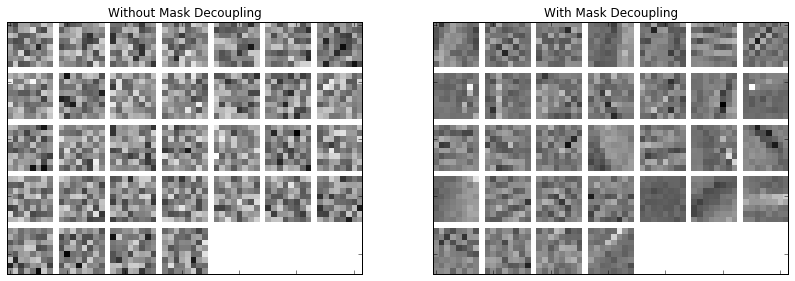

In [10]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D1.squeeze()), fig=fig,
            title='Without Mask Decoupling')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D2.squeeze()), fig=fig,
            title='With Mask Decoupling')
fig.show()

Display reference and training images.

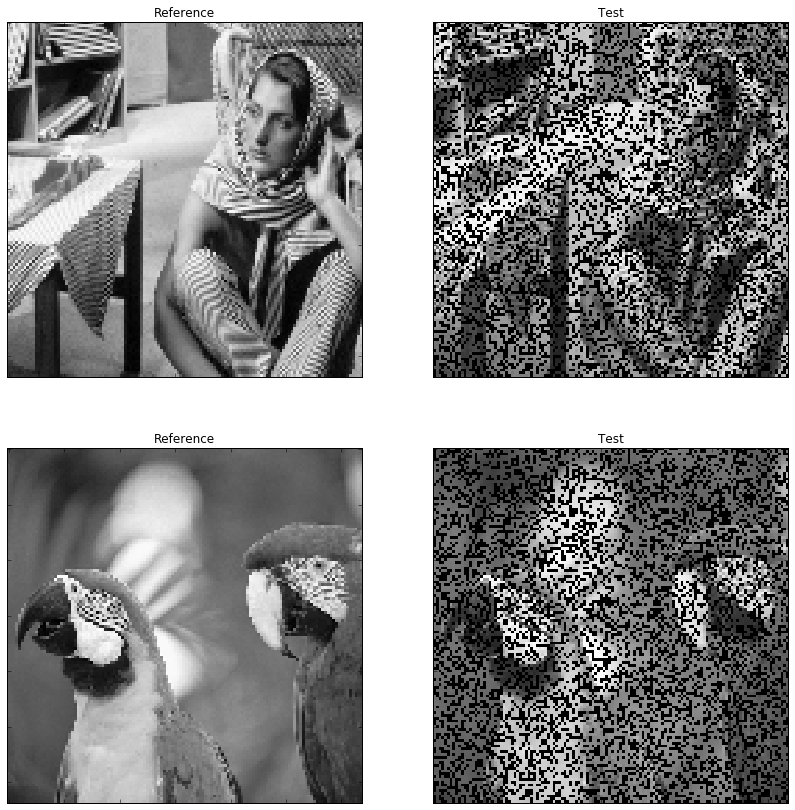

In [11]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(S[...,0], fig=fig, title='Reference')
plot.subplot(2, 2, 2)
plot.imview(Sw[...,0], fig=fig, title='Test')
plot.subplot(2, 2, 3)
plot.imview(S[...,1], fig=fig, title='Reference')
plot.subplot(2, 2, 4)
plot.imview(Sw[...,1], fig=fig, title='Test')
fig.show()

Compare reconstructed images.

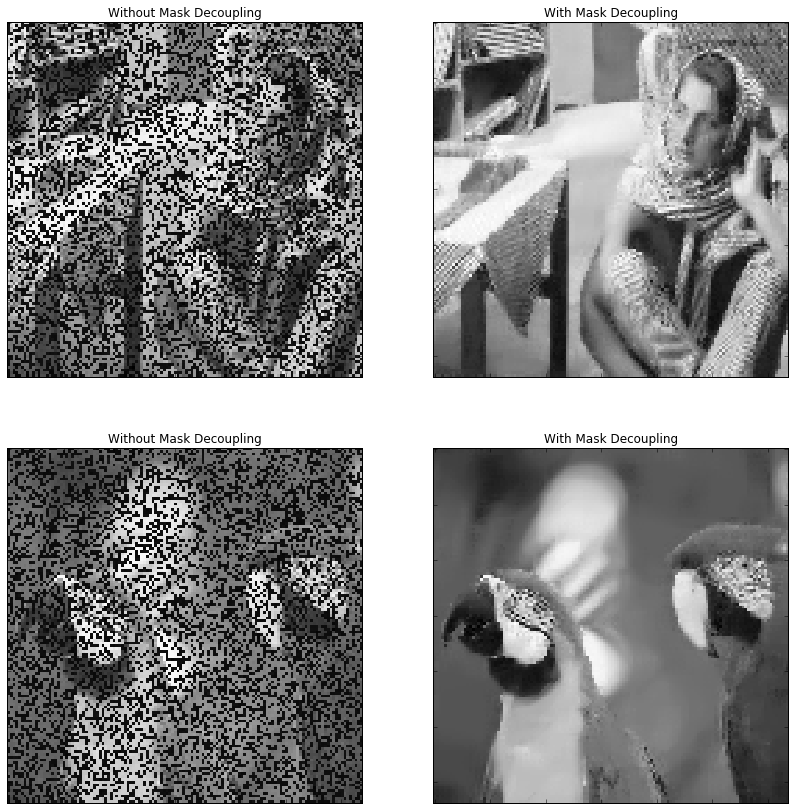

In [12]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(sr1[...,0], fig=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 2)
plot.imview(sr2[...,0], fig=fig, title='With Mask Decoupling')
plot.subplot(2, 2, 3)
plot.imview(sr1[...,1], fig=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 4)
plot.imview(sr2[...,1], fig=fig, title='With Mask Decoupling')
fig.show()